# Spherical Wall Loss Strategy Tutorial

This notebook demonstrates how to use the strategy-based wall loss API in 
**particula**, focusing on `WallLossStrategy` and 
`SphericalWallLossStrategy`.

You will:

- Build a simple radius-based particle distribution using 
`PresetParticleRadiusBuilder`.
- Configure `SphericalWallLossStrategy` for a spherical chamber.
- Integrate wall loss over time and visualize concentration decay.
- See how wall loss strategies can plug into other dynamics components.

For a full chamber forward simulation including dilution and coagulation, 
see the separate `Chamber_Forward_Simulation.ipynb` example in this folder.

## Prerequisites

Before running this notebook, ensure you have:

- Python 3.9 or later
- `particula` installed (via pip or conda)

In Google Colab you can install particula with:

```bash
pip install particula[extra] --quiet
```

In [29]:
# If running in Colab, uncomment the next line to install particula:
# !pip install particula[extra] --quiet

import numpy as np
from matplotlib import pyplot as plt

import particula as par

## 1. Build a lognormal particle distribution

We use `PresetParticleRadiusBuilder` to create a `ParticleRepresentation` 
with radius bins, number concentration, and default physical properties.

In [30]:
# Build a simple radius-based particle distribution (discrete bins)
particle = par.particles.PresetParticleRadiusBuilder().build()

print('Radius shape:', particle.get_radius().shape)
print('Concentration shape:', particle.get_concentration().shape)
print(
    'Total concentration (initial):',
    f'{particle.get_total_concentration():.3e} 1/m^3',
)

Radius shape: (250,)
Concentration shape: (250,)
Total concentration (initial): 1.100e+10 1/m^3


## 2. Configure the spherical wall loss strategy

We now create a `SphericalWallLossStrategy` instance. This strategy 
computes a size-dependent wall loss coefficient and applies a first-order 
loss to the particle concentration.

In [31]:
# Configure spherical wall loss strategy
wall_loss = par.dynamics.SphericalWallLossStrategy(
    wall_eddy_diffusivity=1e-3,  # m^2/s
    chamber_radius=0.5,          # m
    distribution_type='discrete',
)

T = 298.15  # K
P = 101325.0  # Pa

rate = wall_loss.rate(
    particle=particle,
    temperature=T,
    pressure=P,
)

print('Rate array shape:', rate.shape)
print('Example rate[0]:', float(rate.ravel()[0]))

Rate array shape: (250,)
Example rate[0]: -2.2766844125094575e-88


## 3. Integrate wall loss over time

Next, we integrate wall loss for one hour using a fixed time step and 
track the total number concentration as a function of time.

In [ ]:
# Time integration setup
final_time = 6000.0  # s (= 100 minutes)
dt = 1.0           # s
n_steps = int(final_time / dt)

times = np.arange(n_steps + 1) * dt
total_concentration = np.zeros_like(times, dtype=float)

# Record initial concentration
total_concentration[0] = particle.get_total_concentration()

# Time loop: apply only wall loss
for i in range(1, n_steps + 1):
    particle = wall_loss.step(
        particle=particle,
        temperature=T,
        pressure=P,
        time_step=dt,
    )
    total_concentration[i] = particle.get_total_concentration()

print(
    'Total concentration (final):',
    f'{total_concentration[-1]:.3e} 1/m^3',
)

Total concentration (final): 1.009e+10 1/m^3


### Plot normalized concentration decay

We now plot the normalized total number concentration to visualize how 
quickly particles are removed by wall loss.

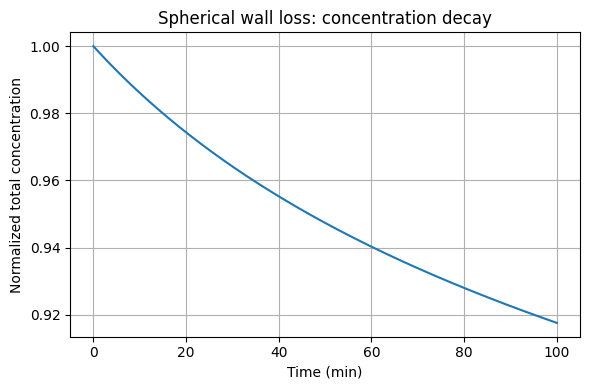

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(times / 60.0, total_concentration / total_concentration[0])

ax.set_xlabel('Time (min)')
ax.set_ylabel('Normalized total concentration')
ax.set_title('Spherical wall loss: concentration decay')
ax.grid(True)

plt.tight_layout()
plt.show()

### Compare initial and final size distributions

Because wall loss is size-dependent, different radii experience different 
loss rates. Here we compare the initial and final size distributions.

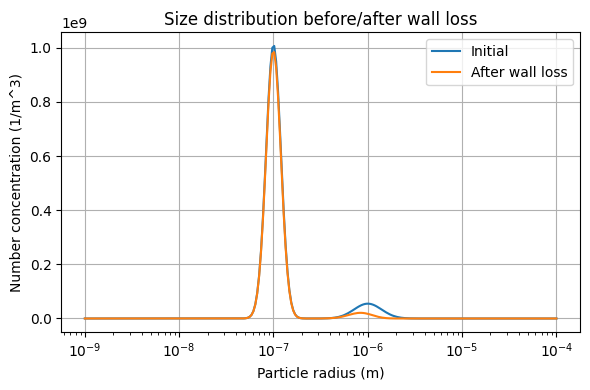

In [34]:
# Rebuild the initial distribution for comparison
initial_particle = par.particles.PresetParticleRadiusBuilder().build()

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    initial_particle.get_radius(),
    initial_particle.get_concentration(),
    label='Initial',
)
ax.plot(
    particle.get_radius(),
    particle.get_concentration(),
    label='After wall loss',
)

ax.set_xscale('log')
ax.set_xlabel('Particle radius (m)')
ax.set_ylabel('Number concentration (1/m^3)')
ax.set_title('Size distribution before/after wall loss')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## 4. Composing wall loss with other dynamics

Wall loss strategies follow the same `rate` / `step` pattern as other 
dynamics components (for example, condensation strategies). This makes it 
easy to combine wall loss with other processes in a single time loop.

The sketch below shows how you might apply wall loss repeatedly. For a 
complete example that combines condensation with wall loss, see the 
condensation tutorials in `docs/Examples/Dynamics/`.

In [35]:
# Pseudo-code: combine condensation and wall loss
particle = par.particles.PresetParticleRadiusBuilder().build()

wall_loss = par.dynamics.SphericalWallLossStrategy(
    wall_eddy_diffusivity=1e-3,
    chamber_radius=0.5,
    distribution_type='discrete',
)

# Note: CondensationIsothermal requires a GasSpecies object. For a complete
# example that includes gas-particle condensation, see the condensation
# tutorials in docs/Examples/Dynamics/.

for _ in range(10):
    # Apply wall loss to the particle distribution
    particle = wall_loss.step(
        particle=particle,
        temperature=T,
        pressure=P,
        time_step=dt,
    )

## Summary

In this notebook you:

- Built a lognormal radius-based particle distribution using 
`PresetParticleRadiusBuilder`.
- Configured `SphericalWallLossStrategy` and computed wall loss rates.
- Integrated wall loss over time and visualized concentration decay.
- Saw how wall loss strategies can be composed with other dynamics 
processes in a shared simulation loop.

For more background on dynamics and wall loss, see the main documentation 
index (Dynamics and wall loss section) and the chamber wall loss examples 
in `docs/Examples/Chamber_Wall_Loss`.